In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import itertools
import math
import re
import lightgbm as lgb

In [2]:
oil_df = pd.read_csv('oil.csv')
holiday_df = pd.read_csv('holidays_events.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')
transaction_df = pd.read_csv('transactions.csv')

In [3]:
train_df['test'] = 0
test_df['test'] = 1
data = pd.concat([train_df, test_df], axis=0)

In [4]:
data = data.merge(holiday_df, on='date', how='left')
data = data.merge(stores_df, on='store_nbr', how='left')
data = data.merge(oil_df, on='date', how='left')
data = data.merge(transaction_df, on=['date','store_nbr'], how='left')
data = data.set_index(['store_nbr', 'date', 'family'])
data = data.drop(index='2013-01-01', level=1)
data

id   sales  onpromotion  \
store_nbr date       family                                                     
1         2013-01-02 AUTOMOTIVE                     1782     2.0            0   
                     BABY CARE                      1783     0.0            0   
                     BEAUTY                         1784     2.0            0   
                     BEVERAGES                      1785  1091.0            0   
                     BOOKS                          1786     0.0            0   
...                                                  ...     ...          ...   
9         2017-08-31 POULTRY                     3029395     NaN            1   
                     PREPARED FOODS              3029396     NaN            0   
                     PRODUCE                     3029397     NaN            1   
                     SCHOOL AND OFFICE SUPPLIES  3029398     NaN            9   
                     SEAFOOD                     3029399     NaN            0   

                                                 test type_x locale  \
store_nbr date       family                                           
1         2013-01-02 AUTOMOTIVE                     0    NaN    NaN   
                     BABY CARE                      0    NaN    NaN   
                     BEAUTY                         0    NaN    NaN   
                     BEVERAGES                      0    NaN    NaN   
                     BOOKS                          0    NaN    NaN   
...                                               ...    ...    ...   
9         2017-08-31 POULTRY                        1    NaN    NaN   
                     PREPARED FOODS                 1    NaN    NaN   
                     PRODUCE                        1    NaN    NaN   
                     SCHOOL AND OFFICE SUPPLIES     1    NaN    NaN   
                     SEAFOOD                        1    NaN    NaN   

                                                locale_name description  \
store_nbr date       family                                               
1         2013-01-02 AUTOMOTIVE                         NaN         NaN   
                     BABY CARE                          NaN         NaN   
                     BEAUTY                             NaN         NaN   
                     BEVERAGES                          NaN         NaN   
                     BOOKS                              NaN         NaN   
...                                                     ...         ...   
9         2017-08-31 POULTRY                            NaN         NaN   
                     PREPARED FOODS                     NaN         NaN   
                     PRODUCE                            NaN         NaN   
                     SCHOOL AND OFFICE SUPPLIES         NaN         NaN   
                     SEAFOOD                            NaN         NaN   

                                                transferred   city      state  \
store_nbr date       family                                                     
1         2013-01-02 AUTOMOTIVE                         NaN  Quito  Pichincha   
                     BABY CARE                          NaN  Quito  Pichincha   
                     BEAUTY                             NaN  Quito  Pichincha   
                     BEVERAGES                          NaN  Quito  Pichincha   
                     BOOKS                              NaN  Quito  Pichincha   
...                                                     ...    ...        ...   
9         2017-08-31 POULTRY                            NaN  Quito  Pichincha   
                     PREPARED FOODS                     NaN  Quito  Pichincha   
                     PRODUCE                            NaN  Quito  Pichincha   
                     SCHOOL AND OFFICE SUPPLIES         NaN  Quito  Pichincha   
                     SEAFOOD                            NaN  Quito  Pichincha   

                                              

In [5]:
data_ = data.copy().reset_index()

train = data_[data_['test'] == 0]
test = data_[data_['test'] == 1]

train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.day_of_week
train['day_of_year'] = train['date'].dt.day_of_year
train['day_of_month'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['quarter'] = train['date'].dt.quarter
train['year'] = train['date'].dt.year

C:\Users\paulw\AppData\Local\Temp\ipykernel_1632\2947704343.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = pd.to_datetime(train['date'])
C:\Users\paulw\AppData\Local\Temp\ipykernel_1632\2947704343.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['day_of_week'] = train['date'].dt.day_of_week
C:\Users\paulw\AppData\Local\Temp\ipykernel_1632\2947704343.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [6]:
grouping_columns = ['year', 'quarter', 'month', 'day_of_week', 'day_of_year', 'day_of_month']

In [7]:
for i, column in enumerate(grouping_columns):
    group_data = train.groupby(column)['sales'].sum()
    group_data = pd.DataFrame(group_data).reset_index()

In [8]:
data_ = data.copy().reset_index()
group_data = data_.groupby(['store_nbr', 'family'])

In [9]:
in_array = [np.exp(1)-1, np.exp(2)-1, 5] 
print ("Input array : ", in_array) 
  
out_array = np.log1p(in_array) 
print ("Output array : ", out_array) 

Input array :  [1.718281828459045, 6.38905609893065, 5]
Output array :  [1.         2.         1.79175947]


alpha
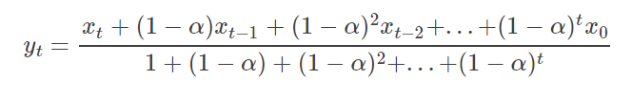

In [10]:
data = pd.Series([10, 8, 9, 12, 15, 14, 13, 11, 10, 9, 8, 10])

# 计算EWMA值，指定alpha参数为0.5
ewma_data = data.ewm(alpha=0.5).mean()

# 输出原始数据和EWMA数据
print("Original Data:\n", data)
print("\nEWMA Data:\n", ewma_data)

Original Data:
 0     10
1      8
2      9
3     12
4     15
5     14
6     13
7     11
8     10
9      9
10     8
11    10
dtype: int64

EWMA Data:
 0     10.000000
1      8.666667
2      8.857143
3     10.533333
4     12.838710
5     13.428571
6     13.212598
7     12.101961
8     11.048924
9     10.023460
10     9.011236
11     9.505739
dtype: float64


In [11]:
data_.describe()

,store_nbr,id,sales,onpromotion,test,cluster,dcoilwtico,transactions
count,3.081078e+06,3.081078e+06,3.052566e+06,3.081078e+06,3.081078e+06,3.081078e+06,2.120580e+06,2.805198e+06
mean,2.750000e+01,1.519128e+06,3.592297e+02,2.659229e+00,9.253904e-03,8.481481e+00,6.780640e+01,1.697082e+03
std,1.558579e+01,8.737819e+05,1.107575e+03,1.236967e+01,9.575110e-02,4.649735e+00,2.564571e+01,9.668321e+02
min,1.000000e+00,1.782000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,5.000000e+00
25%,1.400000e+01,7.631412e+05,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,4.646000e+01,1.046000e+03
50%,2.750000e+01,1.522718e+06,1.100000e+01,0.000000e+00,0.000000e+00,8.500000e+00,5.325000e+01,1.395000e+03
75%,4.100000e+01,2.273386e+06,1.965950e+02,0.000000e+00,0.000000e+00,1.300000e+01,9.572000e+01,2.081000e+03
max,5.400000e+01,3.029399e+06,1.247170e+05,7.410000e+02,1.000000e+00,1.700000e+01,1.106200e+02,8.359000e+03


In [12]:
alphas = [0.95, 0.8, 0.65, 0.5]
lags =[1,7,30]
for a in alphas:
    for i in lags:
        data_[f'sales_lag_{i}_alpha_{a}'] = np.log1p(group_data['sales'].transform(lambda x: x.shift(i).ewm(alpha=a, min_periods=1).mean()))

data_['sales_lag_7_alpha_0.5'].describe()

count    3.068604e+06
mean     3.002727e+00
std      2.665066e+00
min      0.000000e+00
25%      1.550843e-02
50%      2.562952e+00
75%      5.312741e+00
max      1.112374e+01
Name: sales_lag_7_alpha_0.5, dtype: float64

In [13]:
data_['date'] = pd.to_datetime(data_["date"])
data_['day_of_week'] = data_['date'].dt.day_of_week
data_['day_of_year'] = data_['date'].dt.dayofyear
data_['day_of_month'] = data_['date'].dt.day
data_['month'] = data_['date'].dt.month
data_['quarter'] = data_['date'].dt.quarter
data_['year'] = data_['date'].dt.year

In [14]:
data_['onpromotion'] = data_['onpromotion'].apply(lambda x: x>0)
data_

,store_nbr,date,family,id,sales,onpromotion,test,type_x,locale,locale_name,...,sales_lag_30_alpha_0.65,sales_lag_1_alpha_0.5,sales_lag_7_alpha_0.5,sales_lag_30_alpha_0.5,day_of_week,day_of_year,day_of_month,month,quarter,year
0,1,2013-01-02,AUTOMOTIVE,1782,2.0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,1,1,2013
1,1,2013-01-02,BABY CARE,1783,0.0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,1,1,2013
2,1,2013-01-02,BEAUTY,1784,2.0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,1,1,2013
3,1,2013-01-02,BEVERAGES,1785,1091.0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,1,1,2013
4,1,2013-01-02,BOOKS,1786,0.0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,1,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3081073,9,2017-08-31,POULTRY,3029395,NaN,True,1,NaN,NaN,NaN,...,6.287649,5.974924,5.974924,6.252895,3,243,31,8,3,2017
3081074,9,2017-08-31,PREPARED FOODS,3029396,NaN,False,1,NaN,NaN,NaN,...,4.171029,4.907080,4.907080,4.302869,3,243,31,8,3,2017
3081075,9,2017-08-31,PRODUCE,3029397,NaN,True,1,NaN,NaN,NaN,...,7.681655,7.568340,7.568340,7.619194,3,243,31,8,3,2017
3081076,9,2017-08-31,SCHOOL AND OFFICE SUPPLIES,3029398,NaN,True,1,NaN,NaN,NaN,...,5.008067,5.005573,5.005573,4.814117,3,243,31,8,3,2017


In [15]:
sales_lag_cols = list(data_.filter(like='lag').columns)
sales_lag_cols

['sales_lag_1_alpha_0.95',
 'sales_lag_7_alpha_0.95',
 'sales_lag_30_alpha_0.95',
 'sales_lag_1_alpha_0.8',
 'sales_lag_7_alpha_0.8',
 'sales_lag_30_alpha_0.8',
 'sales_lag_1_alpha_0.65',
 'sales_lag_7_alpha_0.65',
 'sales_lag_30_alpha_0.65',
 'sales_lag_1_alpha_0.5',
 'sales_lag_7_alpha_0.5',
 'sales_lag_30_alpha_0.5']

In [16]:
training_percentage = 0.8
testing_percentage = 0.2

In [17]:
to_dummies = ['day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'store_nbr', 'type_y', 'cluster', 'family', 'onpromotion', 'type_x',
       'locale', 'locale_name', 'city', 'state']
X = data_.loc[:, [ 'day_of_week', 'day_of_month', 'month', 'quarter', 'year', 'store_nbr', 'type_y', 'cluster', 'family', 'onpromotion', 'type_x',
       'locale', 'locale_name',  'city', 'state', 'test', 'sales', 'id']+ sales_lag_cols]

In [18]:
X[to_dummies] = X[to_dummies].astype('category')

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081078 entries, 0 to 3081077
Data columns (total 30 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   day_of_week              category
 1   day_of_month             category
 2   month                    category
 3   quarter                  category
 4   year                     category
 5   store_nbr                category
 6   type_y                   category
 7   cluster                  category
 8   family                   category
 9   onpromotion              category
 10  type_x                   category
 11  locale                   category
 12  locale_name              category
 13  city                     category
 14  state                    category
 15  test                     int64   
 16  sales                    float64 
 17  id                       int64   
 18  sales_lag_1_alpha_0.95   float64 
 19  sales_lag_7_alpha_0.95   float64 
 20  sales_lag_30_alpha_0.95 

In [20]:
data_train = X[X['test'] == 0]
data_test = X[X['test'] == 1]

In [21]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28512 entries, 3052566 to 3081077
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   day_of_week              28512 non-null  category
 1   day_of_month             28512 non-null  category
 2   month                    28512 non-null  category
 3   quarter                  28512 non-null  category
 4   year                     28512 non-null  category
 5   store_nbr                28512 non-null  category
 6   type_y                   28512 non-null  category
 7   cluster                  28512 non-null  category
 8   family                   28512 non-null  category
 9   onpromotion              28512 non-null  category
 10  type_x                   1782 non-null   category
 11  locale                   1782 non-null   category
 12  locale_name              1782 non-null   category
 13  city                     28512 non-null  category
 14  sta

In [22]:
n = len(data_train)

training_start = 0
training_end = math.floor(n * training_percentage)
validation_start = training_end
validation_end = n

In [23]:
X_train = data_train.loc[training_start:training_end, :].drop(['test','sales','id'], axis=1)
y_train = data_train.loc[training_start:training_end, 'sales']
X_val = data_train.loc[validation_start:validation_end,:].drop(['test','sales','id'], axis=1)
y_val = data_train.loc[validation_start:validation_end,'sales']
X_test = data_test.loc[:,].drop(['test','sales','id'], axis=1)

In [24]:
X_train.columns.tolist()

['day_of_week',
 'day_of_month',
 'month',
 'quarter',
 'year',
 'store_nbr',
 'type_y',
 'cluster',
 'family',
 'onpromotion',
 'type_x',
 'locale',
 'locale_name',
 'city',
 'state',
 'sales_lag_1_alpha_0.95',
 'sales_lag_7_alpha_0.95',
 'sales_lag_30_alpha_0.95',
 'sales_lag_1_alpha_0.8',
 'sales_lag_7_alpha_0.8',
 'sales_lag_30_alpha_0.8',
 'sales_lag_1_alpha_0.65',
 'sales_lag_7_alpha_0.65',
 'sales_lag_30_alpha_0.65',
 'sales_lag_1_alpha_0.5',
 'sales_lag_7_alpha_0.5',
 'sales_lag_30_alpha_0.5']

In [25]:
X_train = X_train.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+','', x))
X_val = X_val.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+','', x))
X_test = X_test.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+','', x))

In [26]:
X_train.columns.tolist()

['day_of_week',
 'day_of_month',
 'month',
 'quarter',
 'year',
 'store_nbr',
 'type_y',
 'cluster',
 'family',
 'onpromotion',
 'type_x',
 'locale',
 'locale_name',
 'city',
 'state',
 'sales_lag_1_alpha_095',
 'sales_lag_7_alpha_095',
 'sales_lag_30_alpha_095',
 'sales_lag_1_alpha_08',
 'sales_lag_7_alpha_08',
 'sales_lag_30_alpha_08',
 'sales_lag_1_alpha_065',
 'sales_lag_7_alpha_065',
 'sales_lag_30_alpha_065',
 'sales_lag_1_alpha_05',
 'sales_lag_7_alpha_05',
 'sales_lag_30_alpha_05']

In [27]:
hyper_params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':['l1','l2'],
    'learning_rate':0.1,
    'feature_fraction':0.9,
    'bagging_fraction':0.7,
    'bagging_fraq':10,
    'verbose':0,
    'max_depth':50,
    'num_leaves':128,
    'max_bin':512
    }

In [28]:
def train_predict(x_train, y_train, x_val, y_val, x_test):
    hyper_params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':['l1','l2'],
    'learning_rate':0.1,
    'feature_fraction':0.9,
    'bagging_fraction':0.7,
    'bagging_fraq':10,
    'verbose':0,
    'max_depth':50,
    'num_leaves':128,
    'max_bin':512
    }
    gbm = lgb.LGBMRegressor(**hyper_params)
    gbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='l1')
    y_pred = gbm.predict(X_val)
    results = pd.concat([y_val.reset_index(drop=True), pd.Series(y_pred)], axis=1).rename(columns={'sales':'y_val', 0:'y_pred'})
    results['y_pred'] = results['y_pred'].clip(0)
    results = results[results['y_val'] > 10]
    print(results)

In [29]:
train_predict(X_train,y_train,X_val,y_val,X_test)

[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytre

In [34]:
cols = list(X_train.filter(like='lag').columns)
x_train_no_lag = X_train.drop(columns=cols, axis=1)
x_val_no_lag = X_val.drop(columns=cols, axis=1)
x_test_no_lag = X_test.drop(columns=cols, axis=1)

In [37]:
train_predict(x_train_no_lag,y_train,x_val_no_lag,y_val,x_test_no_lag)

[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytre

In [32]:

y_pred

[LightGBM] [Warning] Unknown parameter: bagging_fraq
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


array([3.66944556e+00, 9.30152111e-01, 1.40447123e+01, ...,
       1.99178136e+03, 1.47866638e+02, 1.40668855e+01])